In [1]:
from utils.instrument_recognition import feature_preparator
from models.instrument_recognition.FeedForwardSimpleModel import FeedForwardSimpleModel
import numpy as np
import torch
from utils.instrument_recognition import executor
from utils.instrument_recognition import plot_metrics
from utils.instrument_recognition import evaluate
from torch import nn
from utils.genre_classification import plot_confusion_matrix
from sklearn.metrics import classification_report
from utils.instrument_recognition import calculate_accuracy
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from utils.instrument_recognition.evaluate_multilabel import evaluate_multilabel

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
BATCH_SIZE = 8
DEVICE = torch.device('cuda')

In [4]:
dataloaders, idx_to_instrument, instrument_to_idx, shapes = feature_preparator(8, transform = lambda x: np.mean(x, axis = 0))

In [5]:
train, val, test = dataloaders['accordion']

In [6]:
z = next(iter(train))
x = next(iter(val))
c = next(iter(test))

print(z[0].shape, z[1].shape, z[2].shape)
print(x[0].shape, x[1].shape, x[2].shape)
print(c[0].shape, c[1].shape, c[2].shape)
print(shapes)

torch.Size([8, 128]) torch.Size([8]) torch.Size([8])
torch.Size([8, 128]) torch.Size([8]) torch.Size([8])
torch.Size([8, 128]) torch.Size([8]) torch.Size([8])
(14915, 2034, 3051)


 40%|████      | 40/100 [00:17<00:25,  2.34it/s]

Early stop!


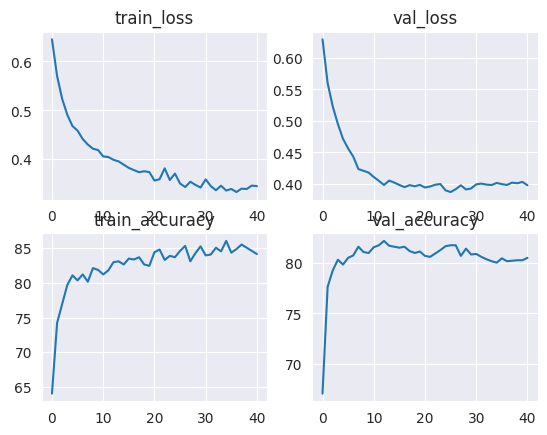

In [7]:
ff_simple_model = FeedForwardSimpleModel(128).to(DEVICE)
train_progress, val_progress = executor(
    DEVICE,
    ff_simple_model,
    train_dataloader = train,
    val_dataloader=val,
    epochs=100,
    learning_rate=0.0001,
    weight_decay=0.01,
    evaluate_per_iteration=20,
    early_stop_after=(15,  0.001)
)

plot_metrics(train_progress, val_progress, metrics = ['loss', 'accuracy'])

              precision    recall  f1-score   support

       False       0.86      0.90      0.88       226
        True       0.63      0.54      0.58        70

    accuracy                           0.82       296
   macro avg       0.75      0.72      0.73       296
weighted avg       0.81      0.82      0.81       296



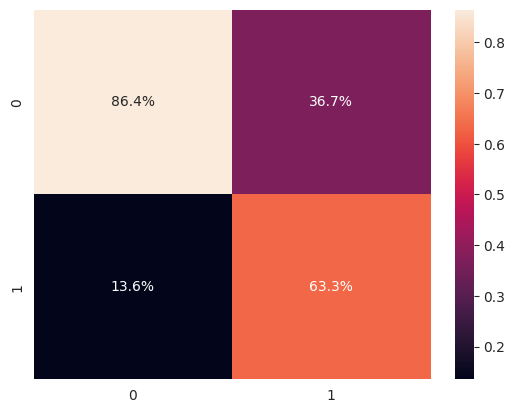

In [8]:
test_loss, test_accuracy, (test_pred, test_true) = evaluate(DEVICE, ff_simple_model, test, criterion=nn.BCEWithLogitsLoss(), return_pred=True)

plot_confusion_matrix(test_true, test_pred)

In [9]:
resulting_pred, resulting_true = [], []
models = {}

for instrument in idx_to_instrument.values():
    model = FeedForwardSimpleModel(128).to(DEVICE)
    train, val, test = dataloaders[instrument]
    train_progress, val_progress = executor(
        DEVICE,
        model,
        train_dataloader=train,
        val_dataloader=val,
        epochs=100,
        learning_rate=0.0001,
        weight_decay=0.01,
        evaluate_per_iteration=20,
        early_stop_after=(15,  0.001)
    )
    test_loss, test_accuracy, (test_pred, test_true) = evaluate(
        DEVICE,
        model,
        test,
        criterion=nn.BCEWithLogitsLoss(),
        return_pred=True
    )

    models[instrument] = model

    resulting_pred.append(test_pred)
    resulting_true.append(test_true)

    # Строим classification_report для тренировочного и тестового датасета
    print('-' * 52)
    print(instrument)

    print('\tTEST')
    print(classification_report(test_true.cpu(), test_pred.cpu(), zero_division=0))


 32%|███▏      | 32/100 [00:12<00:25,  2.62it/s]


Early stop!
----------------------------------------------------
accordion
	TEST
              precision    recall  f1-score   support

       False       0.85      0.95      0.90       227
        True       0.73      0.43      0.55        69

    accuracy                           0.83       296
   macro avg       0.79      0.69      0.72       296
weighted avg       0.82      0.83      0.81       296



 40%|████      | 40/100 [00:16<00:24,  2.46it/s]


Early stop!
----------------------------------------------------
banjo
	TEST
              precision    recall  f1-score   support

       False       0.82      0.86      0.84       187
        True       0.65      0.58      0.61        85

    accuracy                           0.77       272
   macro avg       0.74      0.72      0.73       272
weighted avg       0.77      0.77      0.77       272



 41%|████      | 41/100 [00:13<00:19,  3.10it/s]


Early stop!
----------------------------------------------------
bass
	TEST
              precision    recall  f1-score   support

       False       0.91      0.89      0.90       220
        True       0.62      0.67      0.65        60

    accuracy                           0.84       280
   macro avg       0.77      0.78      0.77       280
weighted avg       0.85      0.84      0.84       280



 44%|████▍     | 44/100 [00:14<00:18,  2.98it/s]


Early stop!
----------------------------------------------------
cello
	TEST
              precision    recall  f1-score   support

       False       0.79      0.79      0.79       149
        True       0.79      0.79      0.79       155

    accuracy                           0.79       304
   macro avg       0.79      0.79      0.79       304
weighted avg       0.79      0.79      0.79       304



 40%|████      | 40/100 [00:16<00:25,  2.38it/s]


Early stop!
----------------------------------------------------
clarinet
	TEST
              precision    recall  f1-score   support

       False       0.82      0.90      0.86       307
        True       0.44      0.28      0.34        85

    accuracy                           0.77       392
   macro avg       0.63      0.59      0.60       392
weighted avg       0.74      0.77      0.75       392



 43%|████▎     | 43/100 [00:13<00:17,  3.27it/s]


Early stop!
----------------------------------------------------
cymbals
	TEST
              precision    recall  f1-score   support

       False       0.96      0.87      0.91        82
        True       0.94      0.98      0.96       174

    accuracy                           0.95       256
   macro avg       0.95      0.92      0.94       256
weighted avg       0.95      0.95      0.94       256



 52%|█████▏    | 52/100 [00:15<00:14,  3.41it/s]


Early stop!
----------------------------------------------------
drums
	TEST
              precision    recall  f1-score   support

       False       0.93      0.86      0.89        97
        True       0.91      0.96      0.94       151

    accuracy                           0.92       248
   macro avg       0.92      0.91      0.91       248
weighted avg       0.92      0.92      0.92       248



 51%|█████     | 51/100 [00:18<00:18,  2.72it/s]


Early stop!
----------------------------------------------------
flute
	TEST
              precision    recall  f1-score   support

       False       0.81      0.87      0.84       227
        True       0.67      0.57      0.62       109

    accuracy                           0.77       336
   macro avg       0.74      0.72      0.73       336
weighted avg       0.76      0.77      0.77       336



 58%|█████▊    | 58/100 [00:15<00:11,  3.63it/s]


Early stop!
----------------------------------------------------
guitar
	TEST
              precision    recall  f1-score   support

       False       0.95      0.91      0.93        96
        True       0.95      0.97      0.96       168

    accuracy                           0.95       264
   macro avg       0.95      0.94      0.94       264
weighted avg       0.95      0.95      0.95       264



 51%|█████     | 51/100 [00:16<00:15,  3.10it/s]


Early stop!
----------------------------------------------------
mallet_percussion
	TEST
              precision    recall  f1-score   support

       False       0.85      0.72      0.78       172
        True       0.66      0.81      0.73       116

    accuracy                           0.75       288
   macro avg       0.75      0.76      0.75       288
weighted avg       0.77      0.75      0.76       288



 32%|███▏      | 32/100 [00:15<00:33,  2.01it/s]


Early stop!
----------------------------------------------------
mandolin
	TEST
              precision    recall  f1-score   support

       False       0.83      0.81      0.82       244
        True       0.62      0.65      0.63       116

    accuracy                           0.76       360
   macro avg       0.72      0.73      0.73       360
weighted avg       0.76      0.76      0.76       360



 25%|██▌       | 25/100 [00:08<00:24,  3.03it/s]


Early stop!
----------------------------------------------------
organ
	TEST
              precision    recall  f1-score   support

       False       0.77      0.90      0.83       191
        True       0.62      0.38      0.47        81

    accuracy                           0.75       272
   macro avg       0.70      0.64      0.65       272
weighted avg       0.73      0.75      0.73       272



 40%|████      | 40/100 [00:11<00:17,  3.50it/s]


Early stop!
----------------------------------------------------
piano
	TEST
              precision    recall  f1-score   support

       False       0.98      0.87      0.92        70
        True       0.96      0.99      0.97       194

    accuracy                           0.96       264
   macro avg       0.97      0.93      0.95       264
weighted avg       0.96      0.96      0.96       264



 33%|███▎      | 33/100 [00:15<00:30,  2.19it/s]


Early stop!
----------------------------------------------------
saxophone
	TEST
              precision    recall  f1-score   support

       False       0.87      0.79      0.83       190
        True       0.79      0.87      0.83       170

    accuracy                           0.83       360
   macro avg       0.83      0.83      0.83       360
weighted avg       0.83      0.83      0.83       360



 51%|█████     | 51/100 [00:14<00:13,  3.53it/s]


Early stop!
----------------------------------------------------
synthesizer
	TEST
              precision    recall  f1-score   support

       False       0.92      0.85      0.88        53
        True       0.95      0.97      0.96       155

    accuracy                           0.94       208
   macro avg       0.93      0.91      0.92       208
weighted avg       0.94      0.94      0.94       208



 53%|█████▎    | 53/100 [00:30<00:27,  1.72it/s]


Early stop!
----------------------------------------------------
trombone
	TEST
              precision    recall  f1-score   support

       False       0.86      0.95      0.90       294
        True       0.78      0.53      0.63        98

    accuracy                           0.84       392
   macro avg       0.82      0.74      0.77       392
weighted avg       0.84      0.84      0.83       392



 38%|███▊      | 38/100 [00:24<00:39,  1.58it/s]


Early stop!
----------------------------------------------------
trumpet
	TEST
              precision    recall  f1-score   support

       False       0.81      0.87      0.84       289
        True       0.71      0.60      0.65       151

    accuracy                           0.78       440
   macro avg       0.76      0.74      0.75       440
weighted avg       0.77      0.78      0.77       440



 51%|█████     | 51/100 [00:25<00:24,  1.97it/s]


Early stop!
----------------------------------------------------
ukulele
	TEST
              precision    recall  f1-score   support

       False       0.83      0.87      0.85       247
        True       0.69      0.62      0.65       113

    accuracy                           0.79       360
   macro avg       0.76      0.74      0.75       360
weighted avg       0.79      0.79      0.79       360



 44%|████▍     | 44/100 [00:15<00:19,  2.88it/s]


Early stop!
----------------------------------------------------
violin
	TEST
              precision    recall  f1-score   support

       False       0.78      0.69      0.73       121
        True       0.87      0.91      0.89       279

    accuracy                           0.84       400
   macro avg       0.82      0.80      0.81       400
weighted avg       0.84      0.84      0.84       400



 53%|█████▎    | 53/100 [00:14<00:12,  3.71it/s]

Early stop!
----------------------------------------------------
voice
	TEST
              precision    recall  f1-score   support

       False       0.91      0.86      0.89        96
        True       0.89      0.93      0.91       112

    accuracy                           0.90       208
   macro avg       0.90      0.90      0.90       208
weighted avg       0.90      0.90      0.90       208



In [10]:
print('INSTRUMENT MACRO ACCURACY:', calculate_accuracy(torch.concat(resulting_pred), torch.concat(resulting_true)))

INSTRUMENT MACRO ACCURACY: 82.8550033569336


''

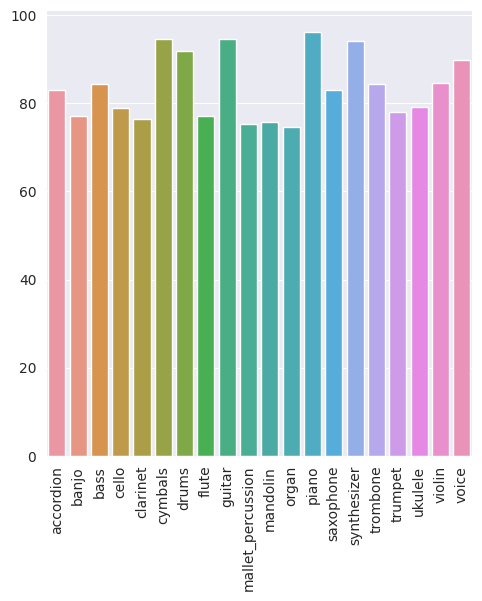

In [11]:
sns.catplot(
    pd.DataFrame(
        columns=idx_to_instrument.values(),
        data=[[calculate_accuracy(*x) for x in zip(resulting_pred, resulting_true)]]
    ),
    kind = 'bar'
)
plt.xticks(rotation=90)
;

In [27]:
test_dataloaders = {
    key: value[2] for key, value in dataloaders.items()
}

true_matrix, pred_matrix = evaluate_multilabel(DEVICE, models, matrix_shape=(shapes[2], len(instrument_to_idx)), dataloaders=test_dataloaders, instrument_to_idx=instrument_to_idx)

In [29]:
def squeeze_answer_matrix(matrix: np.array):
    return list(
        map(
            lambda x: np.array(list(filter(lambda y: not np.isnan(y), x))),
            matrix.tolist()
        )
    )

def get_exact_match_ratio(m_true, m_pred):
    correct = 0
    total = len(m_pred)
    for _pred, _true in zip(m_pred, m_true):
        if np.all(_pred == _true):
            correct += 1

    return correct / total

def get_accuracy(m_true, m_pred):
    acc = 0
    total = len(m_pred)
    for _pred, _true in zip(m_pred, m_true):
        numerator = sum(np.logical_and(_true, _pred))
        denominator = sum(np.logical_or(_true, _pred))
        acc +=  numerator / denominator if denominator != 0 else 1

    return acc / total

print('TEST')
m1 = squeeze_answer_matrix(true_matrix)
m2 = squeeze_answer_matrix(pred_matrix)
print(f'Exact Match Ratio {get_exact_match_ratio(m1, m2)}')
print(f'Accuracy {get_accuracy(m1, m2)}')

TEST
Exact Match Ratio 0.70632579482137
Accuracy 0.7544520922102042
